# ERA5

## Import packages

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://propplt.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://propplt.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
# import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

# Import some extra functions from utils folder
import sys
sys.path.insert(1, 'utils') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

/home/lalandmi/miniconda3/envs/numlab/lib/python3.10/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]
Virtual memory usage - total: 30 GB / available: 8 GB / percent used: 73.9 %


## Download ERA5

1. Go to https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download
2. Search `ERA5 monthly averaged data on single levels from 1940 to present`
3. Download:
    - Product type: Monthly averaged reanalysis
    - Variable: 2m temperature
    - Select all years (except 2021) / months / time
    - Geographical area: Whole available region
    - Format: NetCDF (experimental)
4. Login/register to submit request (create an account if you don't have one)
5. Go back down on the page and click on Submit Form
6. Click on download, cancel, then right click on the download button and copy the link path, then paste it on the cell bellow besides the `wget` command

Remark: It should be around 1Go

Other Remark: using cdsapi...

Copernicus also provides a python module `cdsapi` to handle files download. 

On the same screeen where you clicked `download`, clicking `Show API request`provides you the code copied in the next cell. *Here, it is commented out, because cdsapi does not work in binder. But it would work on a local installation. see https://cds.climate.copernicus.eu/api-how-to for details*

This API ([Application Programming Interface](https://www.howtogeek.com/343877/what-is-an-api/)) is valid for the entire Copernicus climate and atmosphere data store, and particularly useful for systematic downloads



In [ ]:
"""
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': [
            '1940', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2023',
            '2021',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'format': 'netcdf',
    },
    'download.nc')


"""

In [2]:
!wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache/ba75d865e7d381144835dde0e06c0028.nc

--2024-11-20 15:34:45--  https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache/ba75d865e7d381144835dde0e06c0028.nc
Résolution de object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)… 136.156.136.3
Connexion à object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)|136.156.136.3|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1396525080 (1,3G) [application/netcdf]
Sauvegarde en : « ba75d865e7d381144835dde0e06c0028.nc »

ba75d865e7d38114483 100%[===================>]   1,30G  19,9MB/s    ds 2m 0s   

2024-11-20 15:36:46 (11,1 MB/s) — « ba75d865e7d381144835dde0e06c0028.nc » sauvegardé [1396525080/1396525080]



7. Rename the downloaded file to `ERA5.nc`

## Read ERA5 file

In [71]:
ds = xr.open_dataset('ERA5.nc')
ds # ds as dataset

<xarray.Dataset>
Dimensions:    (date: 1018, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 ...
  * date       (date) int64 19400101 19400201 19400301 ... 20240901 20241001
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    expver     (date) object ...
Data variables:
    t2m        (date, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-07T19:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [72]:
ds.date

<xarray.DataArray 'date' (date: 1018)>
array([19400101, 19400201, 19400301, ..., 20240801, 20240901, 20241001])
Coordinates:
    number   int64 ...
  * date     (date) int64 19400101 19400201 19400301 ... 20240901 20241001
    expver   (date) object ...
Attributes:
    long_name:  original GRIB coordinate for key: date(date)
    units:      1

In [73]:
pd.date_range('1940-01', '2024-10', freq='MS')

DatetimeIndex(['1940-01-01', '1940-02-01', '1940-03-01', '1940-04-01',
               '1940-05-01', '1940-06-01', '1940-07-01', '1940-08-01',
               '1940-09-01', '1940-10-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=1018, freq='MS')

In [74]:
ds['date'] = pd.date_range('1940-01', '2024-10', freq='MS')
ds = ds.rename({'date': 'time', 'latitude': 'lat', 'longitude': 'lon'})
ds = ds.sel(time=slice('1940', '2023'))
ds

<xarray.Dataset>
Dimensions:  (time: 1008, lat: 721, lon: 1440)
Coordinates:
    number   int64 ...
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2023-12-01
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    expver   (time) object ...
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-07T19:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# Let's try to get the temperature in °C (uncomment this cell and run this once)
# da = ds.t2m - 273.15
# da

Oups if you are on Binder the kernel as shut down! This is because we have a very limited available amount of RAM (2Go). So we are going to have to trick to make this computation... Hopefully `xarray` comes with `dask` that allows easy parallel computation. Here we are not going to use the parallelization, but we are going to take advantage of Dask for splitting our data into multiple chunks to reduce to RAM usage!

See more: http://xarray.pydata.org/en/stable/user-guide/dask.html

## Check size

In [75]:
# https://stackoverflow.com/a/14822210/6344670
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [76]:
convert_size(ds.t2m.nbytes)

'3.9 GB'

## Make chunks
http://xarray.pydata.org/en/stable/user-guide/dask.html#what-is-a-dask-array

![](http://xarray.pydata.org/en/stable/_images/dask_array.png)

In [77]:
ds.dims

Frozen({'time': 1008, 'lat': 721, 'lon': 1440})

In [78]:
ds = ds.chunk(chunks={"lon": 360, "lat": 360})
ds

<xarray.Dataset>
Dimensions:  (time: 1008, lat: 721, lon: 1440)
Coordinates:
    number   int64 ...
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2023-12-01
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    expver   (time) object dask.array<chunksize=(1008,), meta=np.ndarray>
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1008, 360, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-07T19:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [79]:
ds.t2m.data

dask.array<xarray-t2m, shape=(1008, 721, 1440), dtype=float32, chunksize=(1008, 360, 360), chunktype=numpy.ndarray>

You can see that our dataset have been splited into 12 chunks of about 250 MB what is better than the 2 Go full array! So let's try back to convert to °C!

In [80]:
da = ds.t2m - 273.15
da

<xarray.DataArray 't2m' (time: 1008, lat: 721, lon: 1440)>
dask.array<sub, shape=(1008, 721, 1440), dtype=float32, chunksize=(1008, 360, 360), chunktype=numpy.ndarray>
Coordinates:
    number   int64 ...
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2023-12-01
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    expver   (time) object dask.array<chunksize=(1008,), meta=np.ndarray>

As you can see the execution of the cell is almost instantaneous. Why is this?Because the advantage of `dask.array` is that it is not loaded into memory until explicitly requested with `.load()`, `.compute()` or `.values`. It only builds graphs to prepare the computation. 

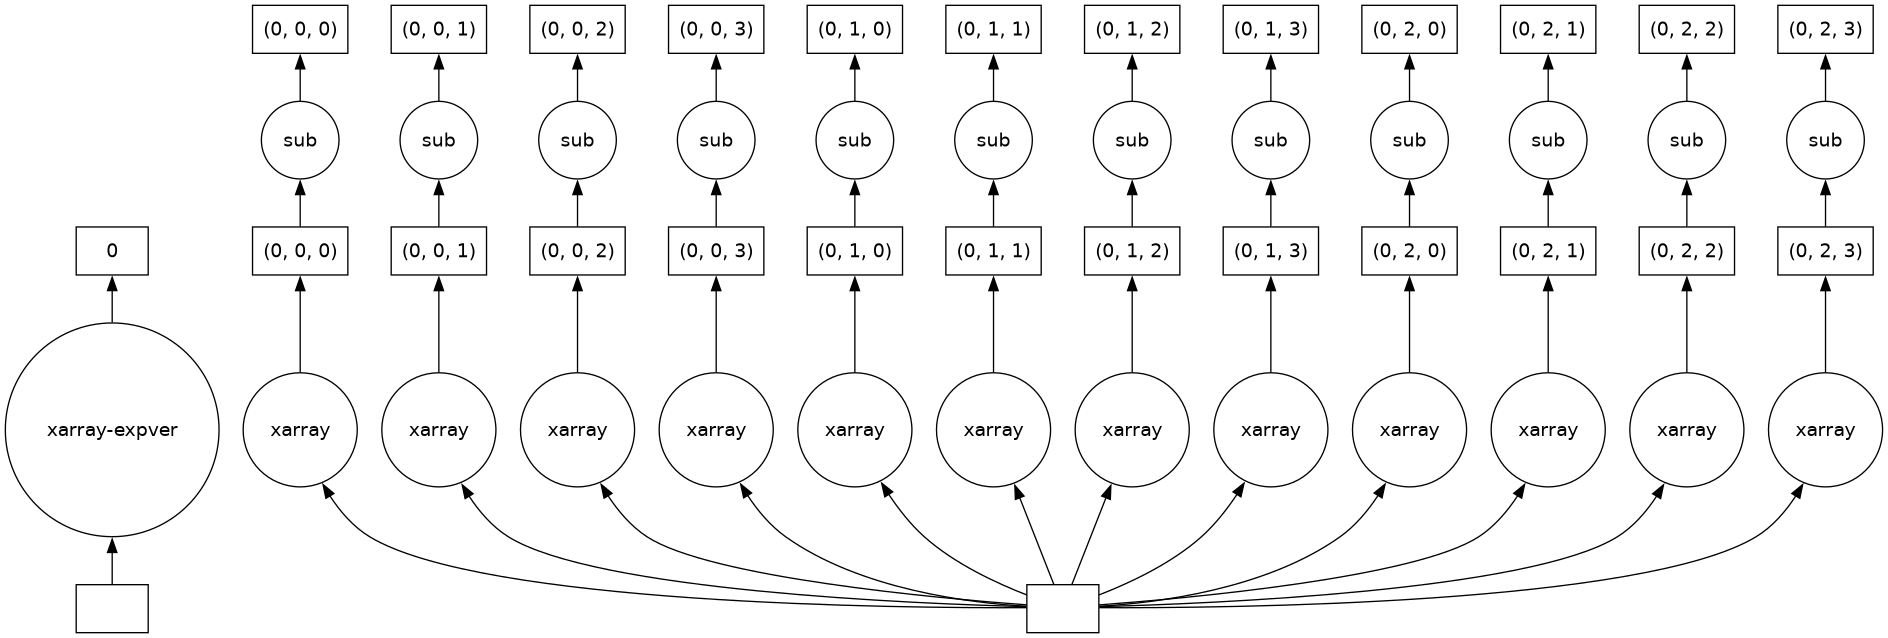

In [81]:
dask.visualize(da)

## Compute and plot climatology
Using the examples in the notebook `01_xarray_get_started.ipynb` try to calculate the climatology and make a graph with a projection (directly with Cartopy or Proplot). 

Remember to check the size of your `dask.array` before loading it into memory (`clim.load()`), which will make it easier to produce the graph (otherwise it will redo the calculation every time you make a graph).

In [82]:
clim = da.mean('time')
clim

<xarray.DataArray 't2m' (lat: 721, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(360, 360), chunktype=numpy.ndarray>
Coordinates:
    number   int64 0
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

In [83]:
clim.load()

<xarray.DataArray 't2m' (lat: 721, lon: 1440)>
array([[-14.951123, -14.951123, -14.951123, ..., -14.951123, -14.951123,
        -14.951123],
       [-14.939844, -14.939669, -14.939544, ..., -14.940334, -14.940139,
        -14.940041],
       [-14.890813, -14.890454, -14.890056, ..., -14.891947, -14.891664,
        -14.891303],
       ...,
       [-45.212944, -45.212048, -45.210278, ..., -45.215557, -45.214027,
        -45.21311 ],
       [-45.32368 , -45.32241 , -45.321117, ..., -45.3258  , -45.325096,
        -45.32443 ],
       [-45.858532, -45.858532, -45.858532, ..., -45.858532, -45.858532,
        -45.858532]], dtype=float32)
Coordinates:
    number   int64 0
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

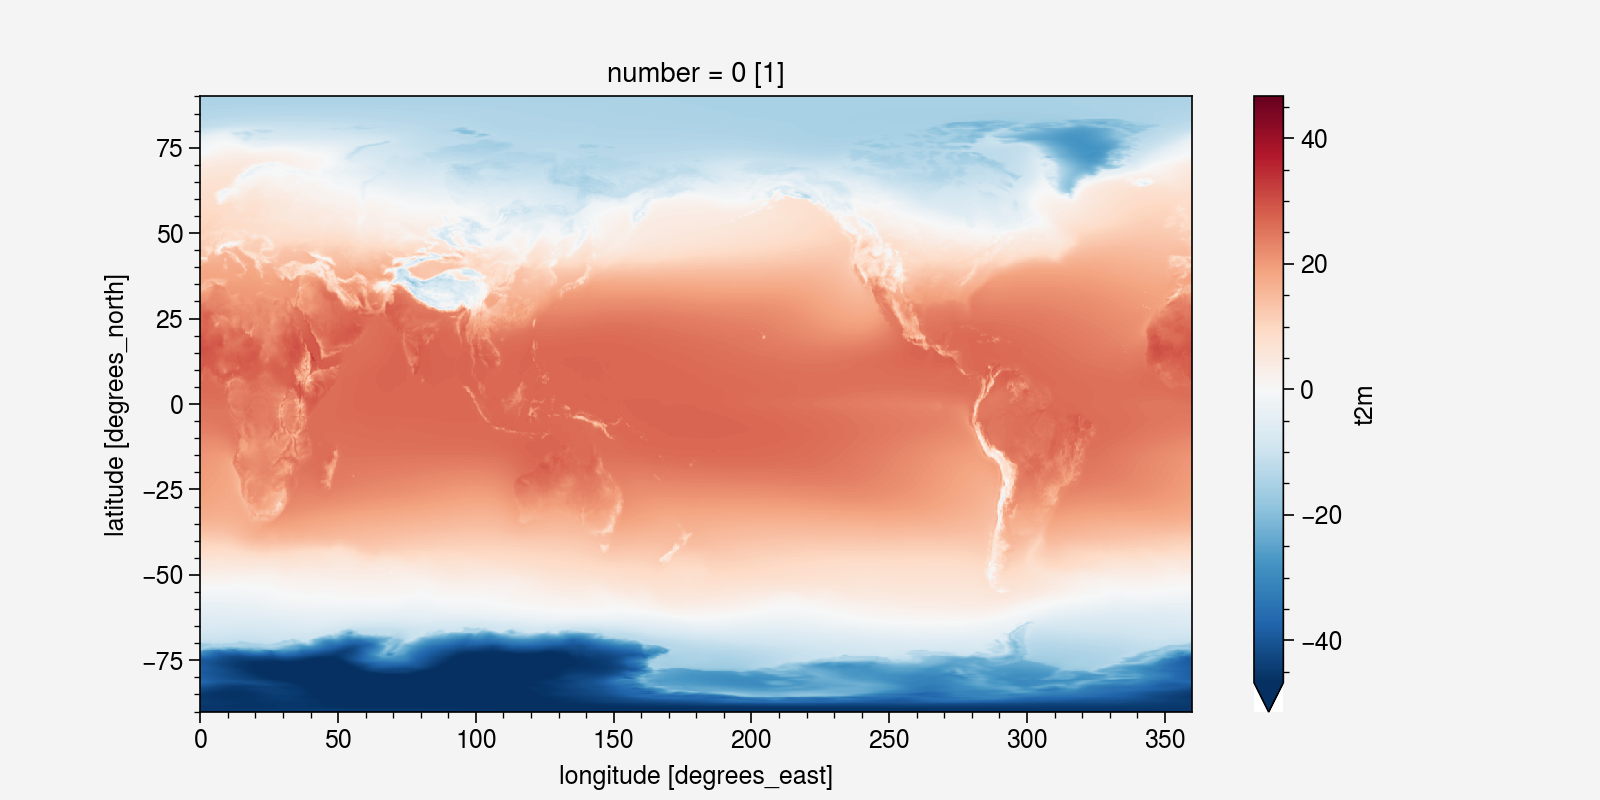

In [84]:
%matplotlib inline
plt.figure(figsize=(8,4))
clim.plot(robust=True)

### Exercise
Try to make a figure with a geographical projection of your choice using proplot (or directly matplotlib/cartopy). See back `01_xarray_get_started.ipynb` to help you.

### Solution
Example of a solution with proplot

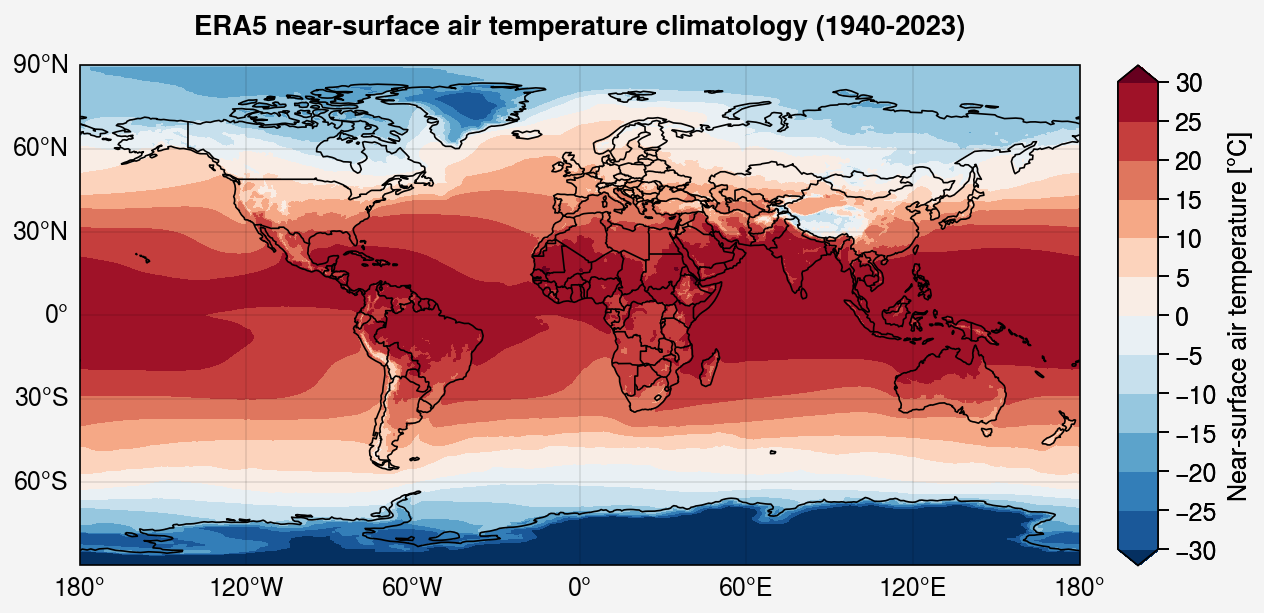

In [86]:
cmap='RdBu_r'
levels=pplt.arange(-30,30,5)
extend='both'

fig, axs = pplt.subplots(nrows=1, ncols=1, proj='cyl', axwidth=5)
# fig, axs = pplt.subplots(nrows=1, ncols=1, proj='robin', axwidth=5)

axs[0].contourf(
    clim, colorbar='r', cmap=cmap, levels=levels, extend=extend, 
    colorbar_kw={'label': 'Near-surface air temperature [°C]'}
)

axs.format(
    labels=True, coast=True, borders=True,
    suptitle='ERA5 near-surface air temperature climatology (1940-2023)'
)

## Seasonal and regional plots
### Exercise
Try to make seasonal climatology plots focused on the country you come from.

Since the longitude data goes from 0 to 360, it is a bit more complicated if your region is around longitude 0. Two solutions, either you use the `.roll()` function to shift your whole dataset, or you use a mask with `.where()` (this last solution seems to me the easiest). You can also use the option `globe=True` in your `contourf()` with proplot to fill the 0 longitude.

Also note that the latitudes are in descending order. So you have to reverse the values in the `.slice()`

### Solution
Example over France

#### Select zone

In [87]:
import warnings
warnings.filterwarnings("ignore")

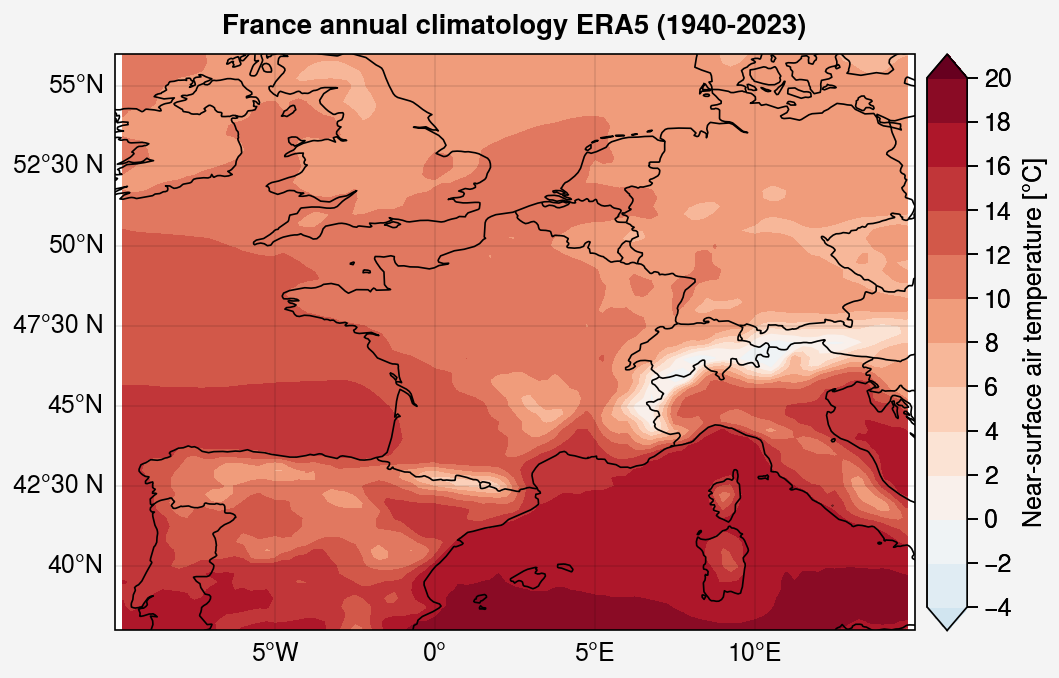

In [88]:
cmap='RdBu_r'
levels=pplt.arange(-4,20,2)
extend='both'
latmin=38 ; latmax=56 ; lonmin=-10 ; lonmax=15

fig, axs = pplt.subplots(nrows=1, ncols=1, proj='cyl', axwidth=4)

axs[0].contourf(
    clim.sel(lat=slice(latmax,latmin)).where( (clim.lon > 360+lonmin) | (clim.lon < lonmax)), 
    colorbar='r', cmap=cmap, levels=levels, extend=extend, globe=True, 
    norm='div', # norm=pplt.Norm('diverging', fair=False),
    colorbar_kw={'label': 'Near-surface air temperature [°C]'}
)

axs.format(
    labels=True, coast=True, borders=True, reso='med',
    latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
    suptitle='France annual climatology ERA5 (1940-2023)'
)

#### Compute seasonal climatologies

In [89]:
clim_seas = da.sel(lat=slice(latmax,latmin)).where( (clim.lon > 360+lonmin) | (clim.lon < lonmax)) \
                .groupby('time.season').mean('time').load()

#### Plot seasonal climatologies

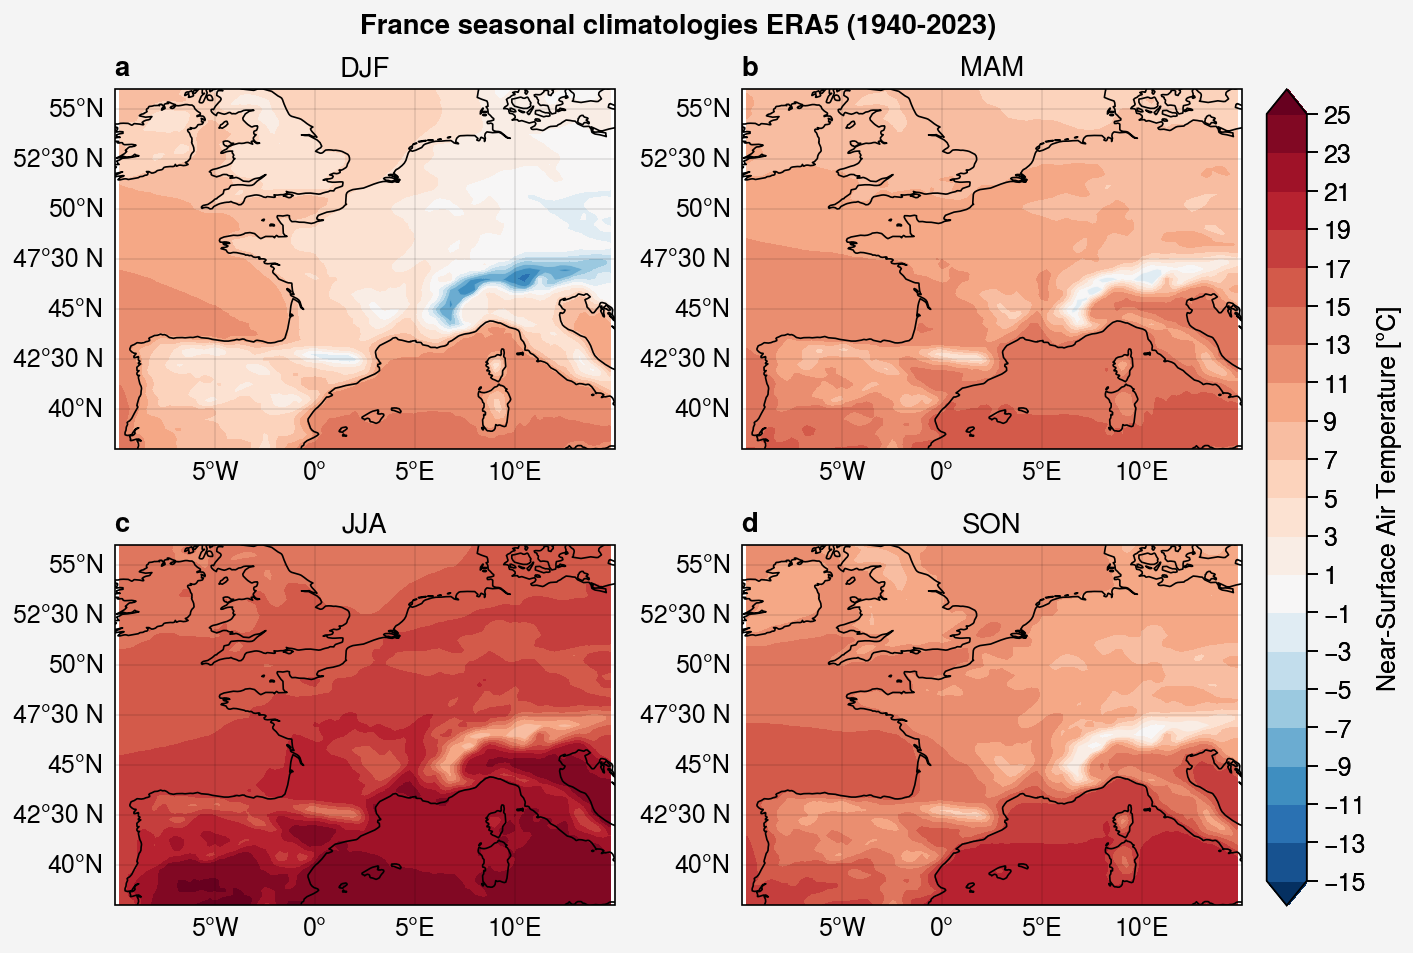

In [90]:
cmap='RdBu_r'
levels=pplt.arange(-15,25,2)
extend='both'

fig, axs = pplt.subplots(nrows=2, ncols=2, proj='cyl')

seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i, ax in enumerate(axs):
    m = ax.contourf(
        clim_seas.sel(season=seasons[i]), cmap=cmap, levels=levels, extend=extend, globe=True, 
        norm=pplt.Norm('diverging', fair=False)
    )
    ax.format(title=seasons[i])

axs.format(
    labels=True, coast=True, abc=True, reso='med',
    latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
    suptitle='France seasonal climatologies ERA5 (1940-2023)'
)

fig.colorbar(m, label='Near-Surface Air Temperature [°C]')
fig.save('img/france_seasonal_clim_t2m.jpg')

## Compute trends

### Exercise: Make yearly mean

Start by resampling the data to annual frequency.

In [104]:
# da_year = ###

### Solution

In [105]:
da_year = da.resample(time='Y').mean('time')
da_year.load()

<xarray.DataArray 't2m' (time: 84, lat: 721, lon: 1440)>
array([[[-14.919995 , -14.919995 , -14.919995 , ..., -14.919995 ,
         -14.919995 , -14.919995 ],
        [-14.964755 , -14.964755 , -14.964755 , ..., -14.964917 ,
         -14.964917 , -14.96508  ],
        [-14.975334 , -14.974846 , -14.974521 , ..., -14.975986 ,
         -14.975986 , -14.975659 ],
        ...,
        [-46.735096 , -46.73477  , -46.733307 , ..., -46.73689  ,
         -46.735584 , -46.734936 ],
        [-46.81648  , -46.81534  , -46.814037 , ..., -46.818104 ,
         -46.81729  , -46.816803 ],
        [-47.43041  , -47.43041  , -47.43041  , ..., -47.43041  ,
         -47.43041  , -47.43041  ]],

       [[-16.053404 , -16.053404 , -16.053404 , ..., -16.053404 ,
         -16.053404 , -16.053404 ],
        [-16.013365 , -16.013039 , -16.012877 , ..., -16.013689 ,
         -16.013689 , -16.013365 ],
        [-15.974301 , -15.974301 , -15.973976 , ..., -15.974953 ,
         -15.97479  , -15.9746275],
...
        [-45.506245 , -45.505108 , -45.503315 , ..., -45.509502 ,
         -45.507874 , -45.506733 ],
        [-45.544006 , -45.54254  , -45.541077 , ..., -45.54661  ,
         -45.545635 , -45.54482  ],
        [-45.974506 , -45.974506 , -45.974506 , ..., -45.974506 ,
         -45.974506 , -45.974506 ]],

       [[-13.47634  , -13.47634  , -13.47634  , ..., -13.47634  ,
         -13.47634  , -13.47634  ],
        [-13.448345 , -13.448508 , -13.448508 , ..., -13.448182 ,
         -13.44802  , -13.448345 ],
        [-13.400331 , -13.400657 , -13.400819 , ..., -13.400982 ,
         -13.400819 , -13.400819 ],
        ...,
        [-44.37283  , -44.37299  , -44.371853 , ..., -44.3725   ,
         -44.372013 , -44.372177 ],
        [-44.343533 , -44.342556 , -44.341904 , ..., -44.343857 ,
         -44.34402  , -44.343533 ],
        [-44.776474 , -44.776474 , -44.776474 , ..., -44.776474 ,
         -44.776474 , -44.776474 ]]], dtype=float32)
Coordinates:
    number   int64 0
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2023-12-31

### Exercise: Spatially averaged time series
Make spatial average.

In [106]:
# ts = ###

### Solution

In [107]:
# Spatially averaged time series (I use a function in the utils folder, same as seen in the tutorial)
ts = u.spatial_average(da_year)
ts.load()

<xarray.DataArray (time: 84)>
array([13.68531263, 13.72967383, 13.63901788, 13.64506943, 13.83645152,
       13.69674381, 13.69982023, 13.74431848, 13.68352672, 13.71597278,
       13.60444705, 13.73684395, 13.72106081, 13.79817119, 13.6012866 ,
       13.5834074 , 13.52395094, 13.77215324, 13.83902454, 13.80389908,
       13.75878806, 13.8344212 , 13.77386462, 13.81086   , 13.59891151,
       13.66083697, 13.73901241, 13.75209385, 13.68980626, 13.82106712,
       13.79587689, 13.64099893, 13.77633579, 13.87973697, 13.60377731,
       13.62872045, 13.55998994, 13.84588822, 13.78695476, 13.94243243,
       14.0736632 , 14.10705704, 13.90776995, 14.10263436, 13.89000533,
       13.84963068, 13.93839604, 14.09379234, 14.12593688, 14.00759857,
       14.2390141 , 14.18425185, 13.95217747, 13.99798584, 14.0343086 ,
       14.21207906, 14.08211599, 14.20433107, 14.39295971, 14.12409264,
       14.11902325, 14.27903223, 14.375714  , 14.36274934, 14.30139567,
       14.46363286, 14.41553928, 14.40813177, 14.27565913, 14.40631533,
       14.50199775, 14.36013855, 14.41127616, 14.43849757, 14.47765649,
       14.62702485, 14.81064267, 14.71508884, 14.63533316, 14.77067616,
       14.8036113 , 14.64513888, 14.67231291, 14.97218087])
Coordinates:
    number   int64 0
  * time     (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2023-12-31

### Plot it

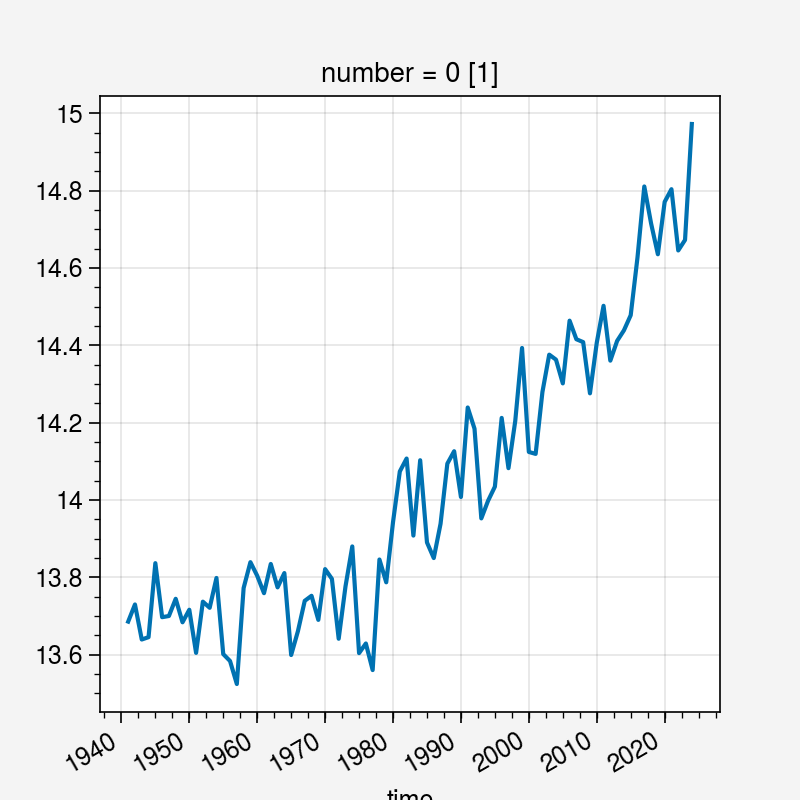

In [108]:
ts.plot()

### Make linear regression
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

In [109]:
# Make linear regression
reg = stats.linregress(ts['time.year'], ts)
reg

LinregressResult(slope=0.013559064884688088, intercept=-12.834797835972225, rvalue=0.9079297927985589, pvalue=1.0387324903599286e-32, stderr=0.0006912120499481479, intercept_stderr=1.3697392154212105)

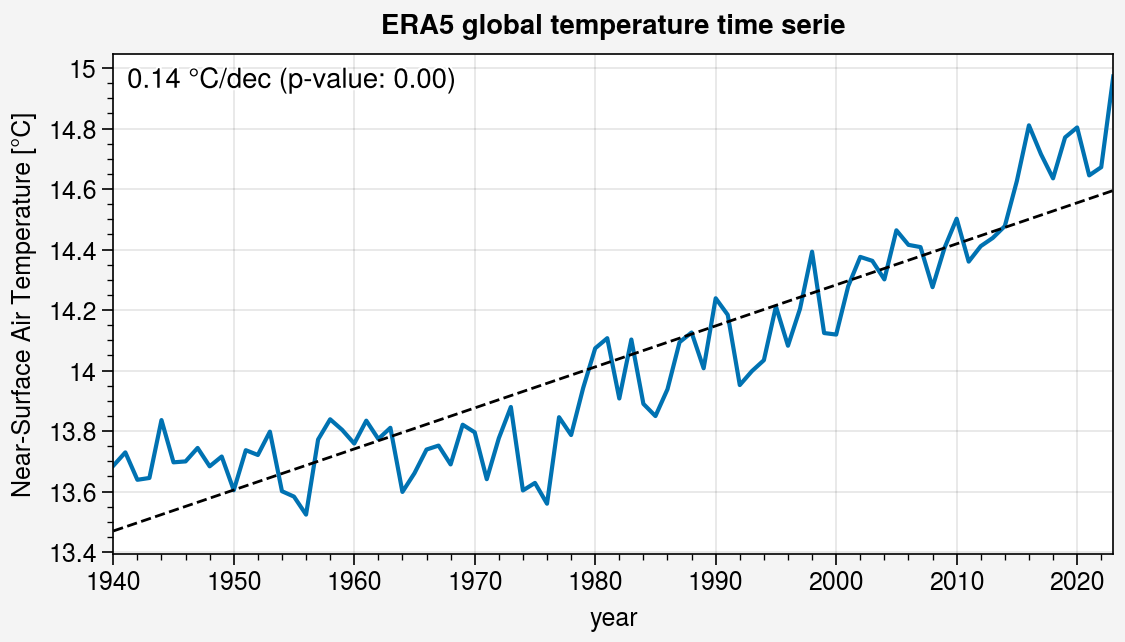

In [112]:
fig, axs = pplt.subplots(axwidth=5, refaspect=2)

x = ts['time.year']

# Plot time serie
axs[0].plot(x, ts)

# Plot regression
y = reg.slope*x + reg.intercept
axs[0].plot(x, y, color='k', linewidth=1, linestyle='--')

# Show regression
axs[0].format(
    ultitle='{:.2f} °C/dec (p-value: {:.2f})'.format(reg.slope*10, reg.pvalue)
)

axs.format(
    xlabel='year',
    ylabel='Near-Surface Air Temperature [°C]',
    suptitle='ERA5 global temperature time serie'
)

In [118]:
x

<xarray.DataArray 'year' (time: 84)>
array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023])
Coordinates:
    number   int64 0
  * time     (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2023-12-31

In [119]:
ts

<xarray.DataArray (time: 84)>
array([13.68531263, 13.72967383, 13.63901788, 13.64506943, 13.83645152,
       13.69674381, 13.69982023, 13.74431848, 13.68352672, 13.71597278,
       13.60444705, 13.73684395, 13.72106081, 13.79817119, 13.6012866 ,
       13.5834074 , 13.52395094, 13.77215324, 13.83902454, 13.80389908,
       13.75878806, 13.8344212 , 13.77386462, 13.81086   , 13.59891151,
       13.66083697, 13.73901241, 13.75209385, 13.68980626, 13.82106712,
       13.79587689, 13.64099893, 13.77633579, 13.87973697, 13.60377731,
       13.62872045, 13.55998994, 13.84588822, 13.78695476, 13.94243243,
       14.0736632 , 14.10705704, 13.90776995, 14.10263436, 13.89000533,
       13.84963068, 13.93839604, 14.09379234, 14.12593688, 14.00759857,
       14.2390141 , 14.18425185, 13.95217747, 13.99798584, 14.0343086 ,
       14.21207906, 14.08211599, 14.20433107, 14.39295971, 14.12409264,
       14.11902325, 14.27903223, 14.375714  , 14.36274934, 14.30139567,
       14.46363286, 14.41553928, 14.40813177, 14.27565913, 14.40631533,
       14.50199775, 14.36013855, 14.41127616, 14.43849757, 14.47765649,
       14.62702485, 14.81064267, 14.71508884, 14.63533316, 14.77067616,
       14.8036113 , 14.64513888, 14.67231291, 14.97218087])
Coordinates:
    number   int64 0
  * time     (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2023-12-31

### Spatial trends
It would be very long to make a loop on each lat/lon, so we can vectorize the calculation with `apply_ufunc` of xarray

In [113]:
def trend(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [114]:
%%time
for arr_name, arr in zip(
    ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], 
    trend(da_year['time.year'], da_year, 'time')
):
    da_year[arr_name] = arr

CPU times: user 11min 34s, sys: 223 ms, total: 11min 34s
Wall time: 11min 34s


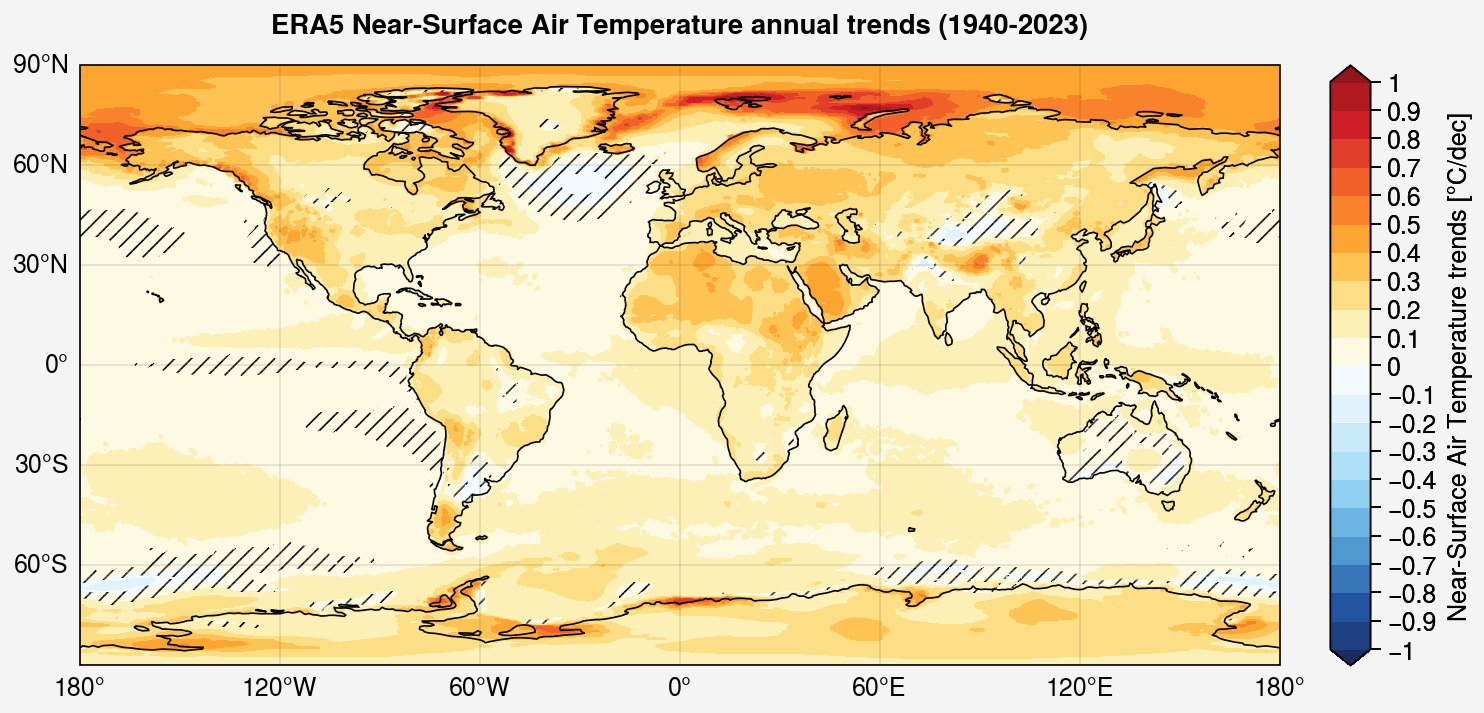

In [115]:
fig, axs = pplt.subplots(proj='cyl', axwidth=6)

cmap='ColdHot'
levels=pplt.arange(-1,1,0.1)
extend='both'

m = axs[0].contourf(da_year.slope*10, cmap=cmap, levels=levels, extend=extend)
axs[0].contourf(da_year.pvalue.where(da_year.pvalue>0.05), hatches=['////'], alpha=0)

fig.colorbar(m, label='Near-Surface Air Temperature trends [°C/dec]', formatter=('simple', 3))

# Format
axs.format(
    labels=True, coast=True,
    suptitle='ERA5 Near-Surface Air Temperature annual trends (1940-2023)'
)

### Exercise: Show Arctic Amplification
Try to show Arctic Amplification with time series

### Solution

In [116]:
ts_arctic = u.spatial_average(da_year.sel(lat=slice(90,60)))

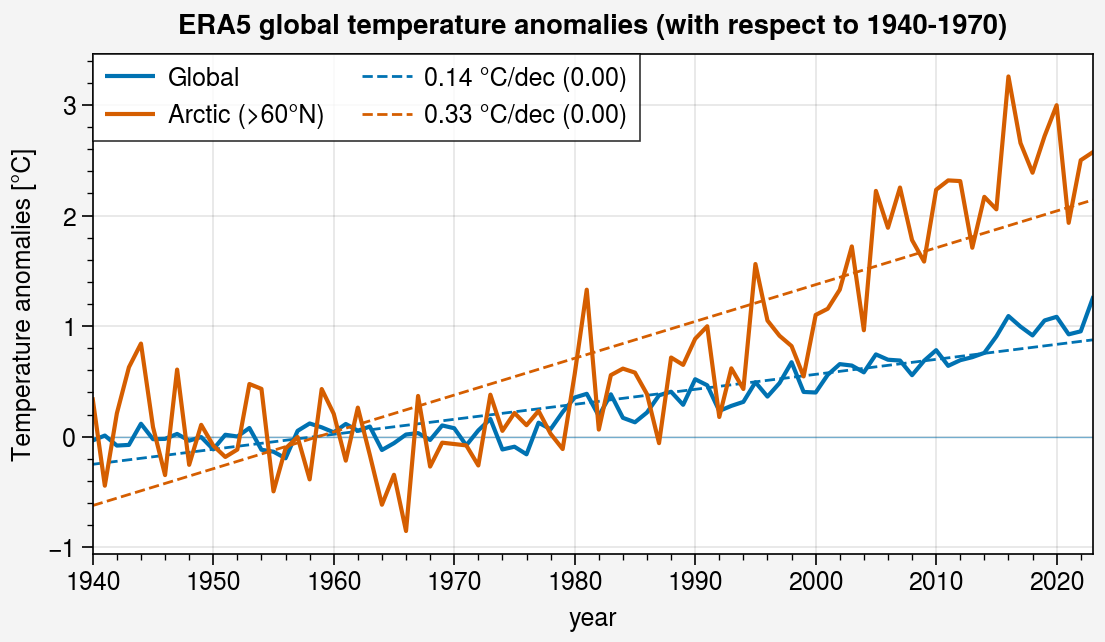

In [117]:
fig, axs = pplt.subplots(axwidth=5, refaspect=2)

x = ts['time.year']

ts_list = [ts, ts_arctic]
labels = ['Global', 'Arctic (>60°N)']

for i, t in enumerate(ts_list):
    # Compute clim on reference period to make anomalies
    clim = t.sel(time=slice('1940', '1970')).mean()
    
    # Plot time serie
    axs[0].plot(x, t-clim, color='C'+str(i), label=labels[i])

    # Plot regression
    reg = stats.linregress(t['time.year'], t-clim)
    y = reg.slope*x + reg.intercept
    axs[0].plot(x, y, color='C'+str(i), linewidth=1, linestyle='--', label='{:.2f} °C/dec ({:.2f})'.format(reg.slope*10, reg.pvalue))

    
axs[0].legend(ncol=2)

# Add 0 line
axs[0].hlines(0, x.min(), x.max(), linewidth=0.5, alpha=0.5)

axs.format(
    xlabel='year',
    ylabel='Temperature anomalies [°C]',
    suptitle='ERA5 global temperature anomalies (with respect to 1940-1970)',
    xlim=(x.min(), x.max())
)